<a href="https://colab.research.google.com/github/itberrios/CV_tracking/blob/main/kitti_tracker/1_kitti_object_detection_lidar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **KITTI 3D Object Detection &rarr; LiDAR-Camera Fusion**

In this tutorial we will dive into the KITTI dataset and detect objects in 3D using Early Sensor [Fusion](https://en.wikipedia.org/wiki/Sensor_fusion) or Early Fusion which aims to fuse raw data from multiple sources and then perform detection. Late fusion on the other hand involves first detecting objects, and then fusing the detections. In this case we will perform a modified fusion, where we detect objects in the camera images and then fuse their centers with the LiDAR data to get depth. 

The main steps are summarized as:

- Detect objects in the camera images (Detection)
- Project 3D LiDAR point clouds to 2D Image space (Fusion)
- Associate LiDAR depth with each Detected object (Association to get Depth)

Detection in 3D as opposed to 2D is much more useful to an autonomous vehicle since 3D detection allows the system know where objects are physically located in the world.

<br>

For more information a readme for the KITTI data can be found [here](https://github.com/yanii/kitti-pcl/blob/master/KITTI_README.TXT), and a paper that details the data collection and coordinate systems can be found [here](http://www.cvlibs.net/publications/Geiger2013IJRR.pdf). 

<br>

Now let's get the data and get started.

In [ ]:
!wget https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_10_03_drive_0047/2011_10_03_drive_0047_sync.zip

--2022-10-09 20:19:05--  https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_10_03_drive_0047/2011_10_03_drive_0047_sync.zip
Resolving s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)... 52.219.75.235
Connecting to s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)|52.219.75.235|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3103291675 (2.9G) [application/zip]
Saving to: ‘2011_10_03_drive_0047_sync.zip’

2011_10_03_drive_00 100%[===================>]   2.89G  14.2MB/s    in 3m 32s  

2022-10-09 20:22:38 (13.9 MB/s) - ‘2011_10_03_drive_0047_sync.zip’ saved [3103291675/3103291675]



In [ ]:
!wget https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_10_03_calib.zip

--2022-10-09 20:22:39--  https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_10_03_calib.zip
Resolving s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)... 52.219.47.99
Connecting to s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)|52.219.47.99|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4075 (4.0K) [application/zip]
Saving to: ‘2011_10_03_calib.zip’

2011_10_03_calib.zi 100%[===================>]   3.98K  --.-KB/s    in 0s      

2022-10-09 20:22:39 (37.8 MB/s) - ‘2011_10_03_calib.zip’ saved [4075/4075]



In [ ]:
!jar xf 2011_10_03_drive_0047_sync.zip
!jar xf 2011_10_03_calib.zip

## Base Library Import

In [ ]:
import os
from glob import glob
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams["figure.figsize"] = (20, 10)

### Import KITTI Utility functions

In [ ]:
!wget https://github.com/itberrios/CV_tracking/raw/main/kitti_tracker/kitti_utils.py
from kitti_utils import *

--2022-10-09 20:26:15--  https://github.com/itberrios/CV_tracking/raw/main/kitti_tracker/kitti_utils.py
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/itberrios/CV_tracking/main/kitti_tracker/kitti_utils.py [following]
--2022-10-09 20:26:15--  https://raw.githubusercontent.com/itberrios/CV_tracking/main/kitti_tracker/kitti_utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9738 (9.5K) [text/plain]
Saving to: ‘kitti_utils.py’

kitti_utils.py      100%[===================>]   9.51K  --.-KB/s    in 0s      

2022-10-09 20:26:15 (88.0 MB/s) - ‘kitti_utils.py’ saved [9738/9738]



## Data Overview

In the KITTI raw dataset we get images from four cameras (two grayscale and two RGB), the velodyne LiDAR, and the OXTS GPS navigation system. 

The update rates are as follows:
- RGB camera: 15 Hz (15 fps)
- OXTS GPS navigation system: 100Hz
- Velodyne LiDAR: 10Hz 

The data is synched to the LiDAR, since it has the lowest update rate, but the sync between the camera, GPS/IMU (navigation), and LiDAR is not precise (even though we are using the synched raw data!). Per the KITTI [description](http://www.cvlibs.net/publications/Geiger2013IJRR.pdf) the worst time difference between the camera/velodyne and gps/imu is at most 5ms. More precise measurements can be obtained with interpolation, but for simplicity we will neglect these differences since the small error from the imprecise sync will not greatly impact our measurements. We will see later when we project LiDAR points onto the camera images, that there is no noticable difference.

<br>
<br>


Now let's get the paths to all of the datafiles, the RGB images are standard .png's, the Navigation frames are .txt files, but the LiDAR point clouds are binary files. The [KITTI README](https://github.com/yanii/kitti-pcl/blob/master/KITTI_README.TXT) describes the structure of the binary files, and we will import a utility function to handle them.

In [ ]:
DATA_PATH = r'2011_10_03/2011_10_03_drive_0047_sync'

# get RGB camera data
left_image_paths = sorted(glob(os.path.join(DATA_PATH, 'image_02/data/*.png')))
right_image_paths = sorted(glob(os.path.join(DATA_PATH, 'image_03/data/*.png')))

# get LiDAR data
bin_paths = sorted(glob(os.path.join(DATA_PATH, 'velodyne_points/data/*.bin')))

# get GPS/IMU data
oxts_paths = sorted(glob(os.path.join(DATA_PATH, r'oxts/data**/*.txt')))

print(f"Number of left images: {len(left_image_paths)}")
print(f"Number of right images: {len(right_image_paths)}")
print(f"Number of LiDAR point clouds: {len(bin_paths)}")
print(f"Number of GPS/IMU frames: {len(oxts_paths)}")

Number of left images: 837
Number of right images: 837
Number of LiDAR point clouds: 837
Number of GPS/IMU frames: 837


## **Camera/LiDAR/IMU Data**

In order to obtain an understanding of the code to follow, it will help to cover the different reference frames that we will be working with and how we can convert between them. The Camera, LiDAR, and IMU are located at different positions on the vehicle and all have different reference frames. In autonomous research, the main vehicle that is collecting perception data (camera/LiDAR) is usually called the ego vehicle.

- camera
  - x &#8594; right
  - y &#8594; down
  - z &#8594; forward
- LiDAR
  - x &#8594; forward
  - y &#8594; left
  - z &#8594; up

- IMU
  - x &#8594; forward
  - y &#8594; left
  - z &#8594; up




  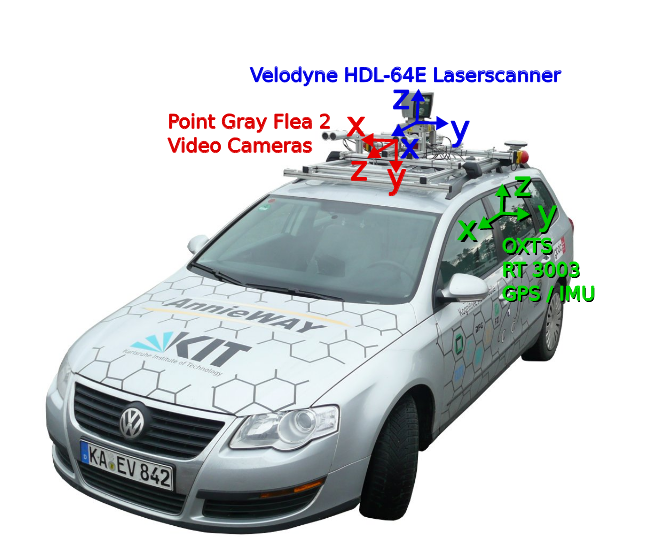

## **LiDAR to Camera**

In order to convert a point from the LiDAR to the camera image space, we must perform four transformations on the point. In this notebook we will transform all points to Camera 2 (the left RGB image), but these equations will allow quick substitution to translate points to any Camera.

The first transformation converts the point from the LiDAR to camera 0 frame of reference via [rigid body transformation](https://www.seas.upenn.edu/~meam620/slides/kinematics0.pdf). NOTE: The camera frame of reference is a 3D point in the world with respect to the camera 0's location 0n the ego vehicle. A rigid transformation is essentially a rotation followed by a translation. A rigid transformation matrix can combine these two components like so:

$$
    T = \begin{bmatrix}
            r_{11} & r_{12} & r_{13} & t_{14} \\ 
            r_{21} & r_{22} & r_{23} & t_{24} \\ 
            r_{31} & r_{32} & r_{33} & t_{34} 
        \end{bmatrix}
$$

Where the r's correspond to the 3x3 rotation matrix and the t's correspond to the 3x1 translation vector.

Next we perform another rigid transformation to go from Camera 0 to Camera 2 (or which ever camera we want to go to).

Next we perform the [rectifying transformation](https://en.wikipedia.org/wiki/Image_rectification), which is just a rotation. We need the rectifying transformtion since we are working the stereo images that are referenced to the same y-axis (i.e. an object on left image has the same y-coordinate as the right image, but not the necessarily the same x-coordinate). When a pair of stereo images are referenced to the same image plane (y-axis) we call them rectified.

Finally we apply the camera [projection](https://en.wikipedia.org/wiki/Camera_matrix) transformation. This gives us the location of a 3D point in 2D image space, which we denote as $(u, v)$ or $(u, v, z)$ if we have depth info.

<br>

#### **LiDAR to Camera Summary**
We can combine these three transformation into a single transformation matrix that will perform the LiDAR to Camera tranformation in a single operation. The LiDAR to Camera transformation matrix will allow us to rotate any 3D LiDAR point to the camera pixel space using the [homogeneous representation](https://en.wikipedia.org/wiki/Homogeneous_coordinates), where the $\tilde{}$ denotes a homogeneous vector. To convert a transformation matrix to it's homogeneous representation, we add a row of new coordinates on the bottom, where 0's will be placed under the rotation portion and a 1 will be placed under the translation portion.

$$
    T = \begin{bmatrix}
            r_{11} & r_{12} & r_{13} & t_{14} \\ 
            r_{21} & r_{22} & r_{23} & t_{24} \\ 
            r_{31} & r_{32} & r_{33} & t_{34} \\
                 0 &      0 &      0 & 1      \\
        \end{bmatrix}
$$


The KITTI [paper](https://www.cvlibs.net/publications/Geiger2013IJRR.pdf) describes the transformation from LiDAR to camera $i$ as follows, where each transformation matrix has been converted to it's homogeneous representation. The difference here is that we have changed the notation and added the transformation to the desired camera reference.

$$ \tilde{y} = P^{cam2}_{rect2} R^{rect2}_{ref2} T^{ref2}_{ref0} T^{ref0}_{velo} \tilde{x},
  \qquad \text{where } \tilde{x} = [x, y, z, 1]^T $$

$$ \tilde{y} = \left( \tilde{u}, \tilde{v}, z, 1 \right) $$

For convenience we will denote the transformation from LiDAR to Camera 2 like so:
$$ T^{cam2}_{velo} = P^{cam2}_{rect2} R^{rect2}_{ref2} T^{ref2}_{ref0} T^{ref0}_{velo} $$

Where 
- $T^{ref}_{velo}$ - LiDAR to Camera Reference &rarr; transforms a 3D point relative to the LiDAR to a 3D point relative to the Camera
- $T^{ref2}_{ref0}$ - Rigid Body Transformation from Camera 0 to Camera 2
- $R^{rect2}_{ref2}$ - Camera 2 to Rectified Camera 2 reference 
- $P^{cam2}_{rect2}$ - Rectified Camera 2 to 2D Camera 2 $(u,v,z)$ coodinate space
- $T^{cam2}_{velo}$ - 3D LiDAR space to 2D Camera 2 $(u,v,z)$ coordinate space.

NOTE: We still denote $(u,v,z)$ as 2D space even though we have $z$ since we are referring to the 2D camera image space with real world depth relative to the camera.

Where $(u,v,z)$ are the final camera coordinates after the rectification and projection transforms. In order to transform from homogeneous image coordinates $\tilde{y}$ to true $(u, v, z)$ image coordinates y, we will need to normalize by the depth and drop the 1, like so:

$$ y = \left( \frac{\tilde{u}}{z}, \frac{\tilde{v}}{z}, z \right) $$

NOTE:
- The notation convention is that the starting refence frame is in the subscript and the ending reference frame is in the superscript
- The '1' added as the 4th coordinate in homogeneous representation is sometimes referred to as 'w'

<br>
<br>

## **Camera to LiDAR**

To transform Camera (u,v,z) (where in this case z will be LiDAR depth in meters) we will need to follow a few steps.

First we need to convert $T^{cam2}_{velo}$ to it's homogeneous representation, we can do that by adding a row of new coordinates on the bottom, where 0's will be placed under the rotation portion and a 1 will be placed under the translation portion.

$$ T^{cam2}_{velo} = \begin{bmatrix}
                     t_{11} & t_{12} & t_{13} & t_{14} \\ 
                     t_{21} & t_{22} & t_{23} & t_{24} \\ 
                     t_{31} & t_{32} & t_{33} & t_{34} \\ 
                          0 &      0 &      0 & 1      \\ 
                    \end{bmatrix}
$$

Next we need to convert $y$ back to it's homogeneous form $\tilde{y}$

$$ \tilde{y} = (u \cdot z,\; v \cdot z,\; z,\; 1) $$

and finally we can get the homogeneous representation in LiDAR coordinates, by inverting the homogeneous transformation [matrix](http://www.info.hiroshima-cu.ac.jp/~miyazaki/knowledge/teche0053.html)


$$ 
\begin{align*}
    T^{velo}_{cam2} &= (T^{cam2}_{velo})^{-1}  \\
    T^{velo}_{cam2} \tilde{y} &= \tilde{x}
\end{align*}
$$

## **IMU to LiDAR**

We will also need to translate IMU to LiDAR, thankfully we have a single matrix $T^{velo}_{imu}$ that will handle this in a single operation.

$$y_{velo} = T^{velo}_{imu} x_{imu}$$

And once we have $y_{velo}$ we can convert it to camera coordiantes using the equations above, or we can compose the transformations, to go from IMU to Camera 2:

$$ 
    T^{cam2}_{imu} =P^{cam2}_{rect2} R^{rect2}_{ref2} T^{ref2}_{ref0} T^{ref0}_{velo} T^{velo}_{imu}
$$

To transform from the Camera to IMU coordiantes, we can do a very similar operation as we did for camera to LiDAR. We just use the homogeneous representation of the transformation matrix and take it's inverse, then we can invert the transform.

$$ 
\begin{align*}
    T^{imu}_{cam2} &= (T^{cam2}_{imu})^{-1}  \\
    T^{imu}_{cam2} \tilde{y}_{cam2} &=  \tilde{x}_{imu}
\end{align*}
$$

<br>
We can transform to any camera $i$ just by replacing $P^{cami}_{recti}$ and $R^{ref}_{rect2}$ with the proper matrices from our calibration file (calib_cam_to_cam.txt

<br>
<br>

## **IMU to Geodetic**

To convert from IMU (x, y, z) coordinates to Geodetic  (Latitude, Longitude, Altitude (Height Above Ellipsoid - HAE)), we can follow these steps:
1. Convert IMU (x, y, z) to (Slant Range, Azimuth, Elevation)
2. Convert (Range, Azimuth, Elevation) to (Latitude, Longitude, HAE)

In step 1 we can convert the (x, y, z) to (Slant Range, Azimuth, Elevation) with 

$$  range = \sqrt{x^2 + y^2 + z^2} \\
    azimuth = tan^{-1}\left( \frac{y}{x} \right) \\
    elevation = tan^{-1} \left(\frac{\sqrt{x^2 + y^2}}{z} \right)
$$

We won't go through the details for step 2 here, we will use pymap3d to handle this.

## **Load Camera Calibration Data**


In [ ]:
with open('2011_10_03/calib_cam_to_cam.txt','r') as f:
    calib = f.readlines()

# get projection matrices (rectified left camera --> left camera (u,v,z))
P_rect2_cam2 = np.array([float(x) for x in calib[25].strip().split(' ')[1:]]).reshape((3,4))


# get rectified rotation matrices (left camera --> rectified left camera)
R_ref0_rect2 = np.array([float(x) for x in calib[24].strip().split(' ')[1:]]).reshape((3, 3,))

# add (0,0,0) translation and convert to homogeneous coordinates
R_ref0_rect2 = np.insert(R_ref0_rect2, 3, values=[0,0,0], axis=0)
R_ref0_rect2 = np.insert(R_ref0_rect2, 3, values=[0,0,0,1], axis=1)


# get rigid transformation from Camera 0 (ref) to Camera 2
R_2 = np.array([float(x) for x in calib[21].strip().split(' ')[1:]]).reshape((3,3))
t_2 = np.array([float(x) for x in calib[22].strip().split(' ')[1:]]).reshape((3,1))

# get cam0 to cam2 rigid body transformation in homogeneous coordinates
T_ref0_ref2 = np.insert(np.hstack((R_2, t_2)), 3, values=[0,0,0,1], axis=0)

## **Load LiDAR and GPS/IMU Calibration Data**

In [ ]:
T_velo_ref0 = get_rigid_transformation(r'2011_10_03/calib_velo_to_cam.txt')
T_imu_velo = get_rigid_transformation(r'2011_10_03/calib_imu_to_velo.txt')

Obtain matrix to transform 3D LiDAR/velo (x, y, z) coordiantes to 2D camera (u,v) coordinates, and it's homogeneous inverse that will allow us to transform from camera (u, v, z, 1) back to LiDAR (x, y, z, 1)

In [ ]:
# transform from velo (LiDAR) to left color camera (shape 3x4)
T_velo_cam2 = P_rect2_cam2 @ R_ref0_rect2 @ T_ref0_ref2 @ T_velo_ref0 

# homogeneous transform from left color camera to velo (LiDAR) (shape: 4x4)
T_cam2_velo = np.linalg.inv(np.insert(T_velo_cam2, 3, values=[0,0,0,1], axis=0)) 

Now we can get the transformation matrix for IMU to camera and cmaera to IMU

In [ ]:
# transform from IMU to left color camera (shape 3x4)
T_imu_cam2 = T_velo_cam2 @ T_imu_velo

# homogeneous transform from left color camera to IMU (shape: 4x4)
T_cam2_imu = np.linalg.inv(np.insert(T_imu_cam2, 3, values=[0,0,0,1], axis=0)) 

Now that we are able to project the LiDAR points onto the image, we can associate points on the image with LiDAR depth. We will use YOLOv5 to detect objects in 2D, then we will find their corresponding depths. Then using our GPS/IMU data we can find out where all of these objects are located in the world via Latitude and Longitude.

<br>

## **Get Object Detection Pipeline**

In [ ]:
!git clone https://github.com/ultralytics/yolov5

Cloning into 'yolov5'...
remote: Enumerating objects: 13703, done.
remote: Counting objects: 100% (505/505), done.
remote: Compressing objects: 100% (161/161), done.
remote: Total 13703 (delta 369), reused 469 (delta 344), pack-reused 13198
Receiving objects: 100% (13703/13703), 13.28 MiB | 18.03 MiB/s, done.
Resolving deltas: 100% (9433/9433), done.


In [ ]:
!pip install -r yolov5/requirements.txt  #Install whatever is needed

In [ ]:
import torch

model = torch.hub.load('ultralytics/yolov5', 'yolov5s')  # or yolov5m, yolov5l, yolov5x, custom

/usr/local/lib/python3.7/dist-packages/torch/hub.py:267: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  "You are about to download and run code from an untrusted repository. In a future release, this won't "
Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /root/.cache/torch/hub/master.zip
YOLOv5 🚀 2022-10-9 Python-3.7.14 torch-1.12.1+cu113 CUDA:0 (Tesla T4, 15110MiB)



  0%|          | 0.00/14.1M [00:00<?, ?B/s]


Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


In [ ]:
# set confidence and IOU thresholds
model.conf = 0.25  # confidence threshold (0-1), default: 0.25
model.iou = 0.25  # NMS IoU threshold (0-1), default: 0.45

## **Detection Pipeline**

Now we can define the main pipeline to get the detections and their center coordinates in multiple reference frames. We will get the object centers in:
- Camera (u, v, z)
- LiDAR (x, y, z)
- IMU (x, y, z)


The basic pipeline is:

1. Detect objects in camera image
2. Project LiDAR point cloud to camera (u,v,z) coordinates
3. Associate object centers with projected (u,v,z) points
4. Transform (u,v,z) objects centers to IMU (x,y,z) coordinates
5. Transform IMU (x,y,z) coordinates to Lat/Lon/Alt

### **1. Detect Objects on image**
Using YOLOv5 out of the box this is a quick 1-liner!

```
detections = model(left_image)
```


### **2. Project LiDAR to (u,v,z)**
We will use a function from our KITTI utils script that will use our rotation matrix $T$ to project (convert) LiDAR (x,y,z) into camera (u,v,z). This function will also handle removing points that fall out of the Feild of View (FOV) of the camera. This function will also remove the ground plane from the LiDAR point cloud using the [RANSAC](https://en.wikipedia.org/wiki/Random_sample_consensus) algorithm in sklearn. RANAC essientially seeks to find the largest plane in the point cloud, and then we remove it.

### **3. Associate Detected Object Centers with (u,v,z) points**
To asscoiate the detected object centers with the (u,v,z) points we compare the [L2 norm](https://montjoile.medium.com/l0-norm-l1-norm-l2-norm-l-infinity-norm-7a7d18a4f40c) of the object bounding box center location to all projected LiDAR (u, v) points. Then we take the point with the smallest L2 norm.

In [ ]:
def get_uvz_centers(image, velo_uvz, bboxes, draw=True):
    ''' Obtains detected object centers projected to uvz camera coordinates. 
        Starts by associating LiDAR uvz coordinates to detected object centers,
        once a match is found, the coordiantes are transformed to the uvz
        camera reference and added to the bboxes array.

        NOTE: The image is modified in place so there is no need to return it.

        Inputs:
          image - input image for detection 
          velo_uvz - LiDAR coordinates projected to camera reference
          bboxes - xyxy bounding boxes form detections from yolov5 model output
          draw - (_Bool) draw measured depths on image
        Outputs:
          bboxes_out - modified array containing the object centers projected
                       to uvz image coordinates
        '''

    # unpack LiDAR camera coordinates
    u, v, z = velo_uvz

    # get new output
    bboxes_out = np.zeros((bboxes.shape[0], bboxes.shape[1] + 3))
    bboxes_out[:, :bboxes.shape[1]] = bboxes

    # iterate through all detected bounding boxes
    for i, bbox in enumerate(bboxes):
        pt1 = torch.round(bbox[0:2]).to(torch.int).numpy()
        pt2 = torch.round(bbox[2:4]).to(torch.int).numpy()

        # get center location of the object on the image
        obj_x_center = (pt1[1] + pt2[1]) / 2
        obj_y_center = (pt1[0] + pt2[0]) / 2

        # now get the closest LiDAR points to the center
        center_delta = np.abs(np.array((v, u)) 
                              - np.array([[obj_x_center, obj_y_center]]).T)
        
        # choose coordinate pair with the smallest L2 norm
        min_loc = np.argmin(np.linalg.norm(center_delta, axis=0))

        # get LiDAR location in image/camera space
        velo_depth = z[min_loc]; # LiDAR depth in camera space
        uvz_location = np.array([u[min_loc], v[min_loc], velo_depth])
        
        # add velo projections (u, v, z) to bboxes_out
        bboxes_out[i, -3:] = uvz_location

        # draw depth on image at center of each bounding box
        # This is depth as perceived by the camera
        if draw:
            object_center = (np.round(obj_y_center).astype(int), 
                             np.round(obj_x_center).astype(int))
            cv2.putText(image, 
                        '{0:.2f} m'.format(velo_depth), 
                        object_center, # top left
                        cv2.FONT_HERSHEY_SIMPLEX, 
                        0.5, # font scale
                        (255, 0, 0), 2, cv2.LINE_AA)    
            
    return bboxes_out


In [ ]:
def get_detection_coordinates(image, bin_path, draw_boxes=True, draw_depth=True):
    ''' Obtains detections for the input image, along with the coordinates of 
        the detected object centers. The coordinate obtained are:
            - Camera with depth --> uvz 
            - LiDAR/velo --> xyz
            - GPS/IMU --> xyz
        Inputs:
            image - rgb image to run detection on
            bin_path - path to LiDAR bin file
        Output:
            bboxes - array of detected bounding boxes, confidences, classes,
            velo_uv - LiDAR points porjected to camera uvz coordinate frame
            coordinates - array of all object center coordinates in the frames
                          listed above
        '''
    ## 1. compute detections in the left image
    detections = model(image)

    # draw boxes on image
    if draw_boxes:
        detections.show() 

    # get bounding box locations (x1,y1), (x2,y2) Prob, class
    bboxes = detections.xyxy[0].cpu() # remove from GPU

    # get LiDAR points and transform them to image/camera space
    velo_uvz = project_velobin2uvz(bin_path, 
                                   T_velo_cam2, 
                                   image, 
                                   remove_plane=True)

    # get uvz centers for detected objects
    bboxes = get_uvz_centers(image, 
                             velo_uvz, 
                             bboxes, 
                             draw=draw_depth)

    return bboxes, velo_uvz

### **4. Transform (u,v,z) objects centers to IMU (x,y,z) coordinates**

To transform the (u,v,z) object centers, we just convert them to homogeneous and use our homogeneous transformation to get the IMU (x,y,z) coordinates.

### **5 Convert IMU to LLA**
Now we need to convert the object IMU (x, y, z) coordinates to Azimuth, Elevation, and Range. Then we can use pymap3d to convert the object centers to Latitude, Longitude, and Altitude. TThe altitude the KITTI dataset does not specify what type of altitude, but the [OXTS documentation](https://www.oxts.com/wp-content/uploads/2020/03/rtman-200302.pdf) states that it can measure either geoidal (MSL) or ellipsoidal (HAE), for details see [this](https://support.pix4d.com/hc/en-us/articles/202559869-Orthometric-vs-ellipsoidal-height). We will go ahead and assume that altitude doesn't matter

In [ ]:
!pip install pymap3d

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 53 kB 2.0 MB/s 


In [ ]:
import pymap3d as pm


def imu2geodetic(x, y, z, lat0, lon0, alt0, heading0):
    ''' Converts cartesian IMU coordinates to Geodetic based on current 
        location. This function works with x,y,z as vectors and lat0, lon0, 
        alt0 as scalars.

        - Correct orientation is provided by the heading
        - The Elevation must be corrected for pymap3d (i.e. 180 is 0 elevation)
        Inputs:
            x - IMU x-coodinate (either scaler of (Nx1) array)
            y - IMU y-coodinate (either scaler of (Nx1) array)
            z - IMU z-coodinate (either scaler of (Nx1) array)
            lat0 - initial Latitude in degrees
            lon0 - initial Longitude in degrees
            alt0 - initial Ellipsoidal Altitude in meters
            heading0 - initial heading in radians (0 - East, positive CCW)
        Outputs:
            lla - (Nx3) numpy array of 
        '''
    # convert to RAE
    rng = np.sqrt(x**2 + y**2 + z**2)
    az = np.degrees(np.arctan2(y, x)) + np.degrees(heading0)
    el = np.degrees(np.arctan2(np.sqrt(x**2 + y**2), z)) + 90 
    
    # convert to geodetic
    lla = pm.aer2geodetic(az, el, rng, lat0, lon0, alt0)

    # convert to numpy array
    lla = np.vstack((lla[0], lla[1], lla[2])).T

    return lla

## **Test the pipeline**

In [ ]:
index = 10

left_image = cv2.cvtColor(cv2.imread(left_image_paths[index]), cv2.COLOR_BGR2RGB)
bin_path = bin_paths[index]
oxts_frame = get_oxts(oxts_paths[index])

# get detections and object centers in uvz
bboxes, velo_uvz = get_detection_coordinates(left_image, bin_path)

# get transformed coordinates of object centers
uvz = bboxes[:, -3:]

# transform to (u,v,z)
# velo_xyz = transform_uvz(uvz, T_cam2_velo) # we can also get LiDAR coordiantes
imu_xyz = transform_uvz(uvz, T_cam2_imu)

# get Lat/Lon on each detected object
lat0 = oxts_frame[0]
lon0 = oxts_frame[1]
alt0 = oxts_frame[2]
heading0 = oxts_frame[5]

lla = imu2geodetic(imu_xyz[:, 0], imu_xyz[:, 1], imu_xyz[:, 2], lat0, lon0, alt0, heading0)

In [ ]:
velo_image = draw_velo_on_image(velo_uvz, np.zeros_like(left_image))

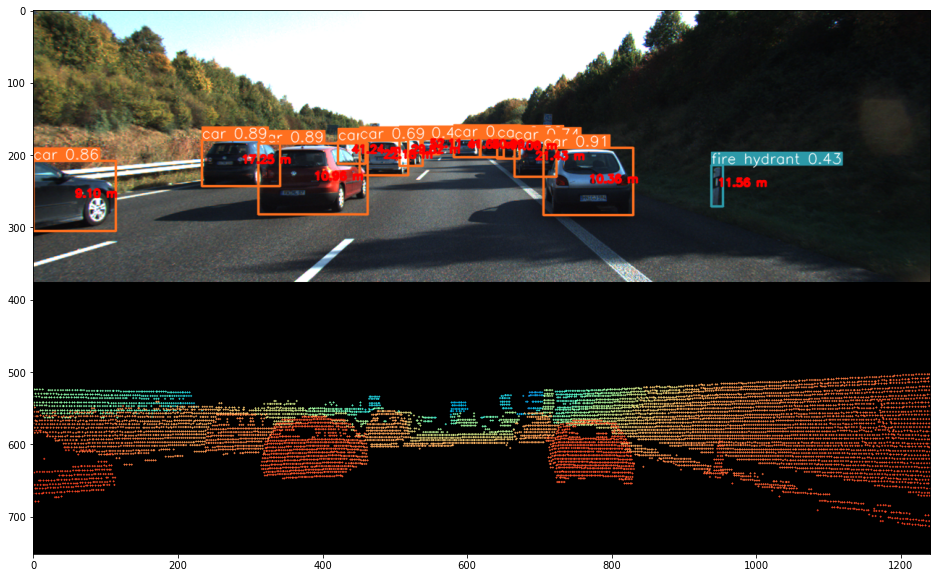

In [ ]:
# pymap3d seems to mess with matplotlib in colab
%matplotlib inline
plt.rcParams["figure.figsize"] = (20, 10)

# stack image with LiDAR point cloud
stacked = np.vstack((left_image, velo_image))

# display stacked iamge
plt.imshow(stacked);

Now just for fun we will project, the LiDAR point cloud onto the camera image. We will see even though there is a slight time difference between the Camer and LiDAR, the points are still aligned with the image objects, confirming that the time difference is negligable for this purpose.

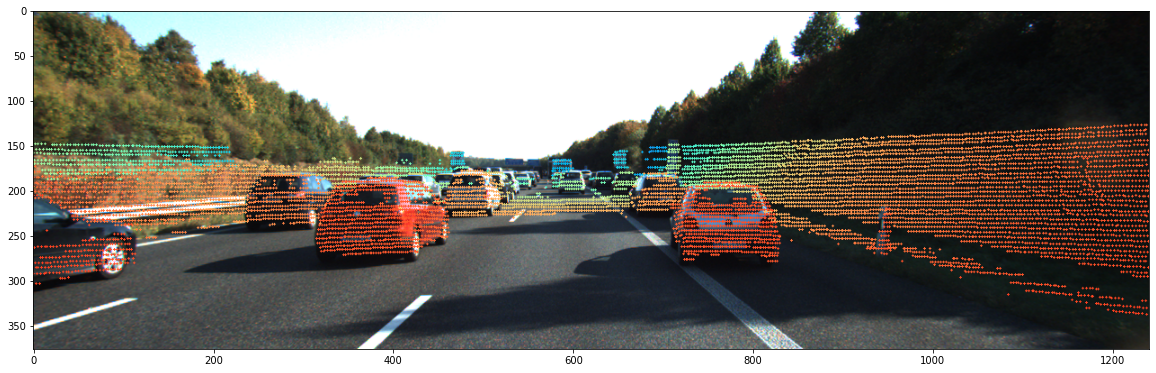

In [ ]:
left_image_2 = cv2.cvtColor(cv2.imread(left_image_paths[index]), cv2.COLOR_BGR2RGB)
velo_image_2 = draw_velo_on_image(velo_uvz, left_image_2)

plt.imshow(velo_image_2);

## **Sanity Checks**

Now that we have the (x, y, z) locations for the detected objects in multiple reference frames, we should perform some sort of sanity checks to ensure that we have correctly implemented the transformations described at the beginning of this notebook. We don't have any truth data for the detected objects, but we do have camera images that we can spot check. The first thing we can do is make note of the (u,v,z) positions, specifcially the z position which is the depth relative to the left color camera. 

We can relate the (u, v) pixel locations and z depths to the objects in the image and spot check for correctness. Now we can spot check our rotation from Camera to IMU. We can look at the diagram below and see that the IMU is 1.08 meters behind the camera. So the $x_{imu}$ value in the imu coordinate frame should be equal to $x_{imu} + z_{cam2} + 1.08$. Remember the depth axis in the IMU coordinate frame is different than that of the camera coordinant frame.

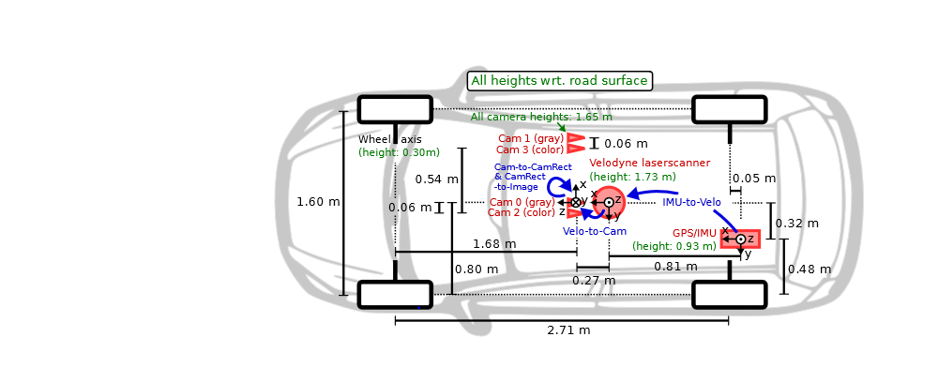

In [ ]:
imu_xyz

array([[     11.446,     -2.4976,    -0.11944],
       [     18.329,      7.4931,    -0.10848],
       [     12.042,       3.171,    -0.15168],
       [     10.179,      6.7471,    -0.27394],
       [     22.516,     -2.7816,   -0.097632],
       [     23.267,      3.5915,    -0.11063],
       [     42.149,     -2.9994,    0.094871],
       [      42.73,     0.25856,    0.035392],
       [     30.901,      3.4319,   -0.079718],
       [     12.655,     -5.6226,    -0.29658],
       [     42.319,      9.3668,    -0.33184],
       [     53.193,      4.1462,    0.099585],
       [     52.078,      -2.119,    -0.14531]])

In [ ]:
uvz

array([[     767.15,      239.49,      10.357],
       [     287.25,      211.88,       17.25],
       [     386.57,      235.75,      10.959],
       [     58.848,      255.17,      9.1014],
       [     694.49,      207.35,      21.425],
       [     485.02,       205.4,      22.184],
       [        657,      190.25,      41.056],
       [     600.06,      190.73,       41.64],
       [     520.37,      197.81,      29.817],
       [     944.73,      245.45,      11.564],
       [     441.19,      196.18,      41.244],
       [     548.04,      187.04,      52.107],
       [     635.03,      191.27,      50.987]])

In [ ]:
(uvz[:, 2] + 1.08) - imu_xyz[:, 0]

array([ -0.0095994,   0.0013328,  -0.0028969,   0.0023714,   -0.010605,  -0.0032876,   -0.013486,  -0.0092651,  -0.0040865,   -0.011558,   0.0044812,  -0.0059038,   -0.010697])

We can see that the errors betwee the theoretical IMU x values and the actual x values are fairly low. For the remaining IMU values we can wee that the y (horizontal) and z (vertical) have numbers that make sense based on the object locations on the image.

Now that we have locations for each object we can recontsruct the scene at each frame, using the LLA locations.

In [ ]:
!pip install folium

In [ ]:
import folium

drive_map = folium.Map(
    location=(lat0, lon0), # starting location
    zoom_start=18
)

# add Lat/Lon points to map
folium.CircleMarker(location=(lat0, lon0),
                    radius=2,
                    weight=5,
                    color='red').add_to(drive_map);

In [ ]:
# place the position of each detection on the map
for pos in lla:
    folium.CircleMarker(location=(pos[0], pos[1]),
                        radius=2,
                        weight=5,
                        color='green').add_to(drive_map);

# add Lat/Lon points to map
folium.CircleMarker(location=(lat0, lon0),
                    radius=2,
                    weight=5,
                    color='red').add_to(drive_map);

In [ ]:
drive_map

Now we can use opencv2 to display the environment detected by the Camera and LiDAR. In this case we will draw a rectangle for every detected object, but you can use the detected MSCOCO class in bboxes and draw custom symbols for each different object. You could also cluster the data in LiDAR space and draw sybols based on the clustered data shape.

In [ ]:
canvas_height = stacked.shape[0]
canvas_width = 500

# get consistent center for ego vehicle
ego_center = (250, int(canvas_height*0.95))

# get rectangle coordiantes for ego vehicle
ego_x1 = ego_center[0] - 5
ego_y1 = ego_center[1] - 10
ego_x2 = ego_center[0] + 5
ego_y2 = ego_center[1] + 10

def draw_scenario(canvas, imu_xyz, sf=12):
    # draw ego vehicle
    cv2.rectangle(canvas, (ego_x1, ego_y1), (ego_x2, ego_y2), (0, 255, 0), -1);

    # draw detected objects
    for val in imu_xyz:
        obj_center = (ego_center[0] - sf*int(np.round(val[1])),
                      ego_center[1] - sf*int(np.round(val[0])))
        # cv2.circle(canvas, obj_center, 5, (255, 0, 0), -1);

        # get object rectangle coordinates
        obj_x1 = obj_center[0] - 5
        obj_y1 = obj_center[1] - 10
        obj_x2 = obj_center[0] + 5
        obj_y2 = obj_center[1] + 10

        cv2.rectangle(canvas, (obj_x1, obj_y1), (obj_x2, obj_y2), (255, 0, 0), -1);


    return canvas

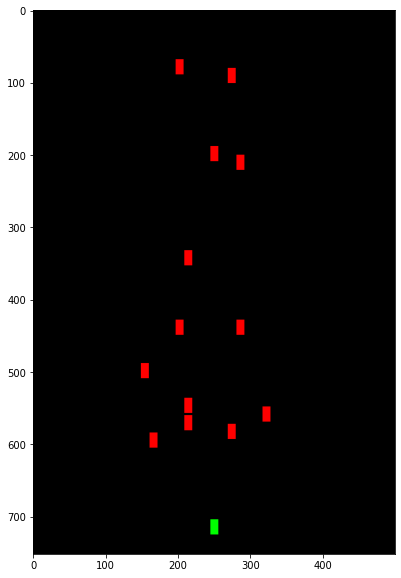

In [ ]:
canvas = np.zeros((canvas_height, canvas_width, 3), dtype=np.uint8)
draw_scenario(canvas, imu_xyz, sf=12)
plt.imshow(canvas);

Now we stack all of the images together into a single frame!

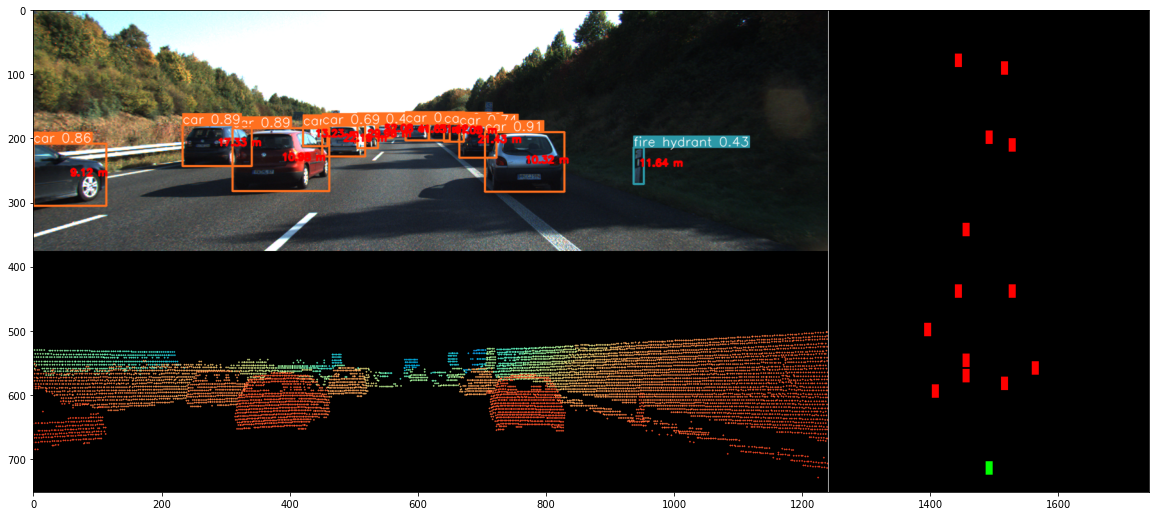

In [ ]:
frame = np.hstack((stacked, 
                  255*np.ones((canvas_height, 1, 3), dtype=np.uint8),
                  canvas))

plt.imshow(frame);

## **Video of Results**

Now we can make a video of our results, but first let's get the average frame rate from the left camera time stamps.

In [ ]:
get_total_seconds = lambda hms: hms[0]*60*60 + hms[1]*60 + hms[2]


def timestamps2seconds(timestamp_path):
    ''' Reads in timestamp path and returns total seconds (does not account for day rollover '''
    timestamps = pd.read_csv(timestamp_path, 
                             header=None, 
                             squeeze=True).astype(object) \
                                          .apply(lambda x: x.split(' ')[1]) 
    
    # Get Hours, Minutes, and Seconds
    hours = timestamps.apply(lambda x: x.split(':')[0]).astype(np.float64)
    minutes = timestamps.apply(lambda x: x.split(':')[1]).astype(np.float64)
    seconds = timestamps.apply(lambda x: x.split(':')[2]).astype(np.float64)

    hms_vals = np.vstack((hours, minutes, seconds)).T
    
    total_seconds = np.array(list(map(get_total_seconds, hms_vals)))
    
    return total_seconds


In [ ]:
cam2_total_seconds = timestamps2seconds(os.path.join(DATA_PATH, r'image_02/timestamps.txt'))

In [ ]:
# camera 2 frames per second
cam2_fps = 1/np.median(np.diff(cam2_total_seconds))
cam2_fps

9.650971459539951

In [ ]:
result_video = []

for index in range(len(left_image_paths)):
    left_image = cv2.cvtColor(cv2.imread(left_image_paths[index]), cv2.COLOR_BGR2RGB)
    bin_path = bin_paths[index]
    oxts_frame = get_oxts(oxts_paths[index])

    # get detections and object centers in uvz
    bboxes, velo_uvz = get_detection_coordinates(left_image, bin_path)

    # get transformed coordinates
    uvz = bboxes[:, -3:]

    # velo_xyz = transform_uvz(uvz, T_cam2_velo) # we can also get LiDAR coordiantes
    imu_xyz = transform_uvz(uvz, T_cam2_imu)

    # draw velo on blank image
    velo_image = draw_velo_on_image(velo_uvz, np.zeros_like(left_image))

    # stack frames
    stacked = np.vstack((left_image, velo_image))

    # draw top down scenario on canvas
    canvas = np.zeros((canvas_height, canvas_width, 3), dtype=np.uint8)
    draw_scenario(canvas, imu_xyz, sf=12)
    
    # place everything in a single frame
    frame = np.hstack((stacked, 
                       255*np.ones((canvas_height, 1, 3), dtype=np.uint8),
                       canvas))

    # add to result video
    result_video.append(frame)

# get width and height for video frames
h, w, _ = frame.shape

In [ ]:
out = cv2.VideoWriter('lidar_frame_stack.avi',
                      cv2.VideoWriter_fourcc(*'DIVX'), 
                      cam2_fps, 
                      (w,h))
 
for i in range(len(result_video)):
    out.write(cv2.cvtColor(result_video[i], cv2.COLOR_BGR2RGB))
out.release()

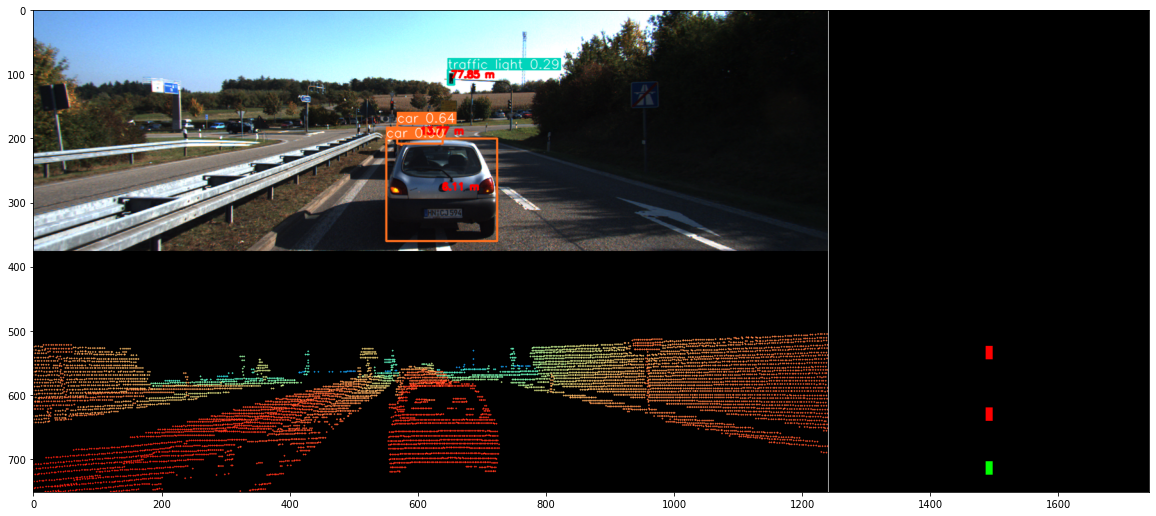

In [ ]:
plt.imshow(frame);